Khởi tạo datasets

In [1]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import random

def augment_hsv(im, hgain= 0, sgain=0.5, vgain=0.5):
    # HSV color-space augmentation
    if hgain or sgain or vgain:
        r = np.random.uniform(-1, 1, 3) * [hgain, sgain, vgain] + 1  # random gains
        hue, sat, val = cv2.split(cv2.cvtColor(im, cv2.COLOR_BGR2HSV))
        dtype = im.dtype  # uint8

        x = np.arange(0, 256, dtype=r.dtype)
        lut_hue = ((x * r[0]) % 180).astype(dtype)
        lut_sat = np.clip(x * r[1], 0, 255).astype(dtype)
        lut_val = np.clip(x * r[2], 0, 255).astype(dtype)

        im_hsv = cv2.merge((cv2.LUT(hue, lut_hue), cv2.LUT(sat, lut_sat), cv2.LUT(val, lut_val)))
        cv2.cvtColor(im_hsv, cv2.COLOR_HSV2BGR, dst=im)  # no return needed


# Change cv2.resize to import data correctly

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path, width, height):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)
        self.width, self.height = width, height

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index])
        image = cv2.resize(image, (self.width, self.height), interpolation = cv2.INTER_LINEAR)
        augment_hsv(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.0 ## (512, 512, 3)
        
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        
        
        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        # mask = cv2.resize(mask, (self.width, self.height), interpolation=cv2.INTER_LINEAR)
        # mask = mask/255.0   ## (512, 512)
        mask = cv2.resize(mask, (160, 80), interpolation=cv2.INTER_LINEAR)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        
        mask = np.where(mask != 0, 1.0, 0.0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask
    def __len__(self):
        return self.n_samples
    

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True



/data/hoangtv/data/AIChallenge/anaconda3/envs/cds/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Khởi tạo hàm loss và hàm tính mIoU

In [16]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F



class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE
    
    

SMOOTH = 1e-6

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor, threshold = 0.5):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    outputs = torch.sigmoid(outputs)
    outputs = (outputs> threshold)
    outputs = outputs.to(dtype=torch.int8)

    labels = labels.to(dtype=torch.int8)
    # print(outputs)
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    print(iou/outputs.shape[0])
    return sum(iou)/outputs.shape[0]  # Or thresholded.mean() if you are interested in average across the batch



Khởi tạo mô hình Unet

In [9]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        #self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, group=out_c)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs


Dataset Size:
Train: 500 - Valid: 200

Epoch: 1
Train...


100%|██████████| 125/125 [00:09<00:00, 13.17it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 40.65it/s]


Mean IoU: 0.6787
Valid loss improved from inf to 0.4360. Saving checkpoint: ./best.pth
	Train Loss: 0.480
	 Val. Loss: 0.436



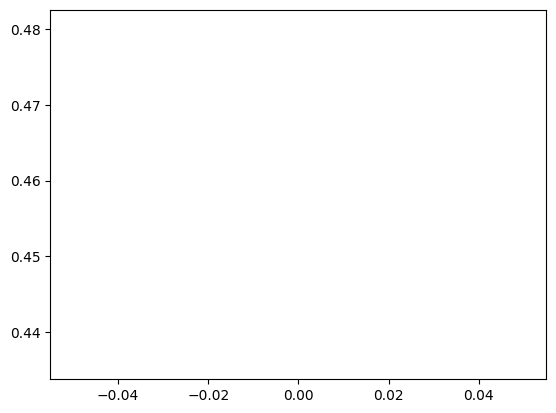

Epoch: 2
Train...


100%|██████████| 125/125 [00:09<00:00, 13.30it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 40.34it/s]


Mean IoU: 0.7279
Valid loss improved from 0.4360 to 0.2536. Saving checkpoint: ./best.pth
	Train Loss: 0.279
	 Val. Loss: 0.254



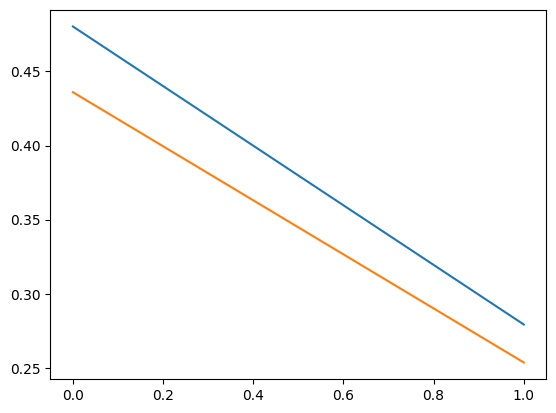

Epoch: 3
Train...


100%|██████████| 125/125 [00:09<00:00, 13.28it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 40.26it/s]


Mean IoU: 0.7298
Valid loss improved from 0.2536 to 0.2231. Saving checkpoint: ./best.pth
	Train Loss: 0.243
	 Val. Loss: 0.223



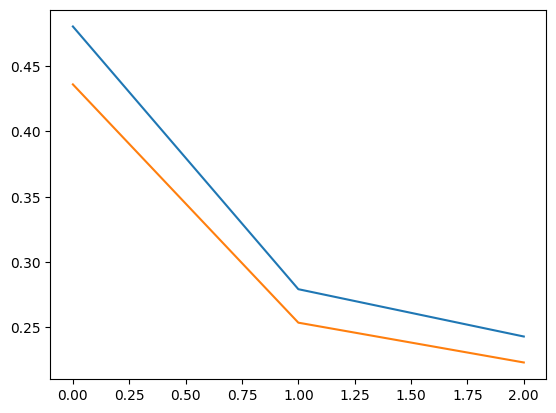

Epoch: 4
Train...


100%|██████████| 125/125 [00:09<00:00, 13.24it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 40.27it/s]


Mean IoU: 0.6698
	Train Loss: 0.174
	 Val. Loss: 0.339



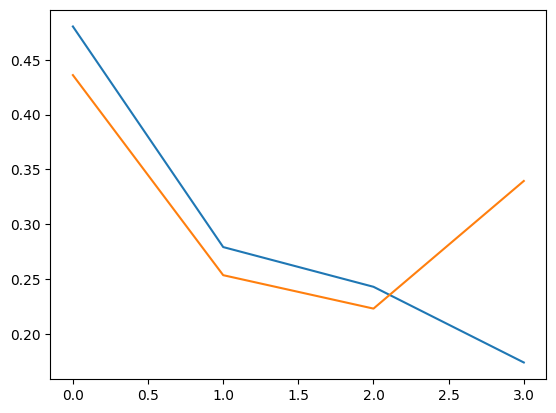

Epoch: 5
Train...


100%|██████████| 125/125 [00:09<00:00, 13.21it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 40.15it/s]


Mean IoU: 0.7153
Valid loss improved from 0.2231 to 0.2163. Saving checkpoint: ./best.pth
	Train Loss: 0.156
	 Val. Loss: 0.216



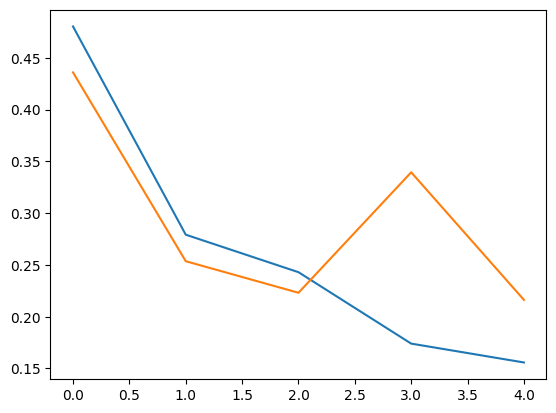

Epoch: 6
Train...


100%|██████████| 125/125 [00:09<00:00, 13.16it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 40.02it/s]


Mean IoU: 0.7234
Valid loss improved from 0.2163 to 0.1334. Saving checkpoint: ./best.pth
	Train Loss: 0.123
	 Val. Loss: 0.133



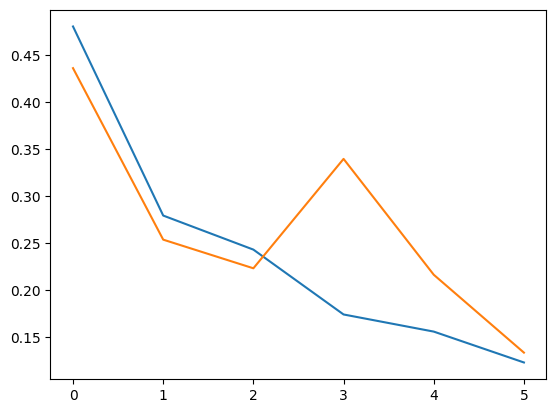

Epoch: 7
Train...


100%|██████████| 125/125 [00:09<00:00, 13.16it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 40.07it/s]


Mean IoU: 0.7327
Valid loss improved from 0.1334 to 0.1093. Saving checkpoint: ./best.pth
	Train Loss: 0.103
	 Val. Loss: 0.109



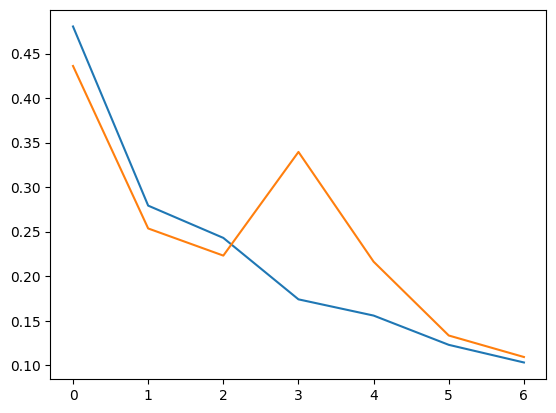

Epoch: 8
Train...


100%|██████████| 125/125 [00:09<00:00, 13.14it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 40.01it/s]


Mean IoU: 0.7252
	Train Loss: 0.088
	 Val. Loss: 0.114



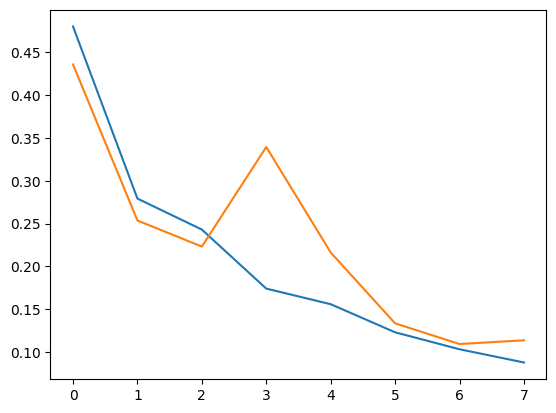

Epoch: 9
Train...


100%|██████████| 125/125 [00:09<00:00, 13.13it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.93it/s]


Mean IoU: 0.7318
Valid loss improved from 0.1093 to 0.0793. Saving checkpoint: ./best.pth
	Train Loss: 0.075
	 Val. Loss: 0.079



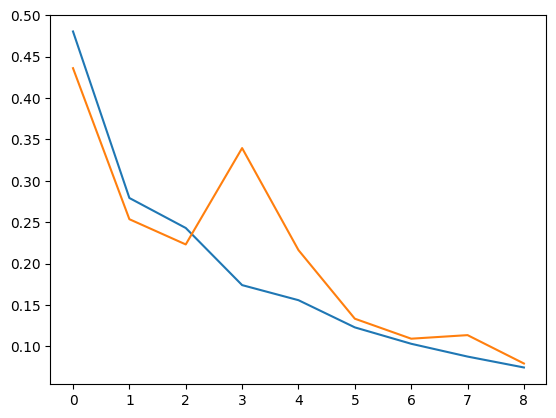

Epoch: 10
Train...


100%|██████████| 125/125 [00:09<00:00, 13.15it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 40.00it/s]


Mean IoU: 0.7324
Valid loss improved from 0.0793 to 0.0669. Saving checkpoint: ./best.pth
	Train Loss: 0.059
	 Val. Loss: 0.067



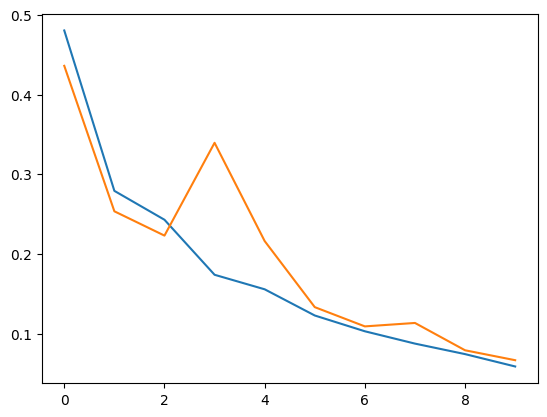

Epoch: 11
Train...


100%|██████████| 125/125 [00:09<00:00, 13.13it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.80it/s]


Mean IoU: 0.7329
Valid loss improved from 0.0669 to 0.0574. Saving checkpoint: ./best.pth
	Train Loss: 0.052
	 Val. Loss: 0.057



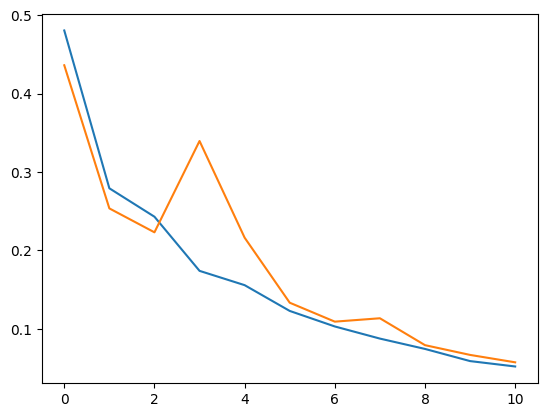

Epoch: 12
Train...


100%|██████████| 125/125 [00:09<00:00, 13.13it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.87it/s]


Mean IoU: 0.7308
	Train Loss: 0.048
	 Val. Loss: 0.064



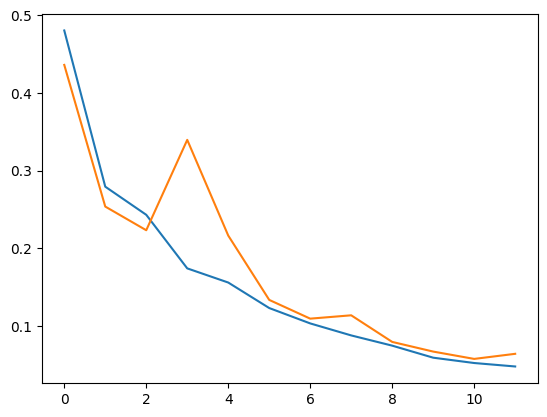

Epoch: 13
Train...


100%|██████████| 125/125 [00:09<00:00, 13.08it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.69it/s]


Mean IoU: 0.7141
	Train Loss: 0.058
	 Val. Loss: 0.129



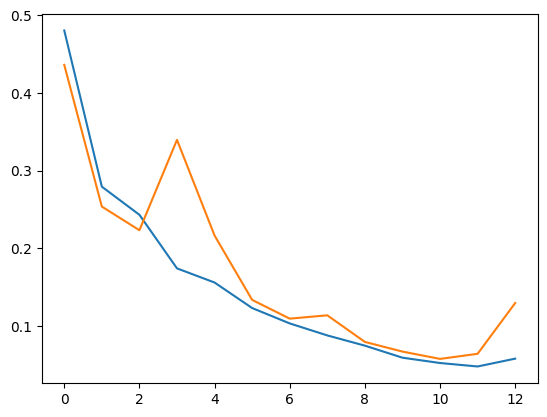

Epoch: 14
Train...


100%|██████████| 125/125 [00:09<00:00, 13.08it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.64it/s]


Mean IoU: 0.7264
	Train Loss: 0.063
	 Val. Loss: 0.078



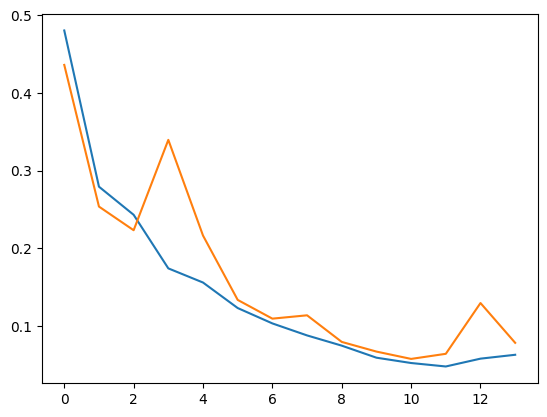

Epoch: 15
Train...


100%|██████████| 125/125 [00:09<00:00, 13.06it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.63it/s]


Mean IoU: 0.7318
Valid loss improved from 0.0574 to 0.0484. Saving checkpoint: ./best.pth
	Train Loss: 0.045
	 Val. Loss: 0.048



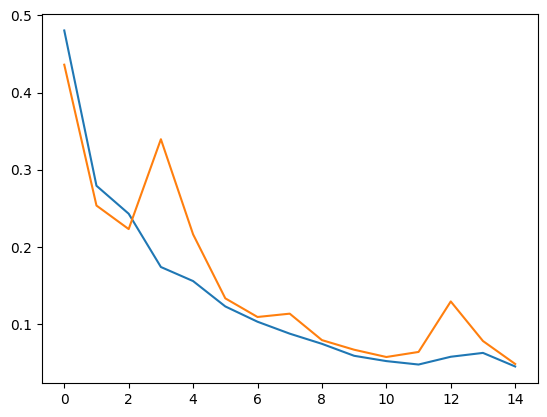

Epoch: 16
Train...


100%|██████████| 125/125 [00:09<00:00, 13.04it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.56it/s]


Mean IoU: 0.7327
Valid loss improved from 0.0484 to 0.0475. Saving checkpoint: ./best.pth
	Train Loss: 0.035
	 Val. Loss: 0.047



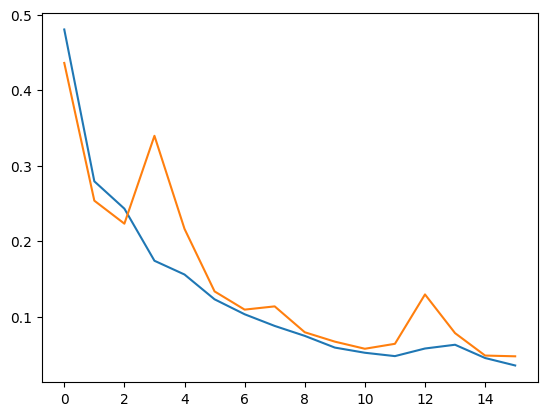

Epoch: 17
Train...


100%|██████████| 125/125 [00:09<00:00, 13.04it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.54it/s]


Mean IoU: 0.6158
	Train Loss: 0.062
	 Val. Loss: 0.587



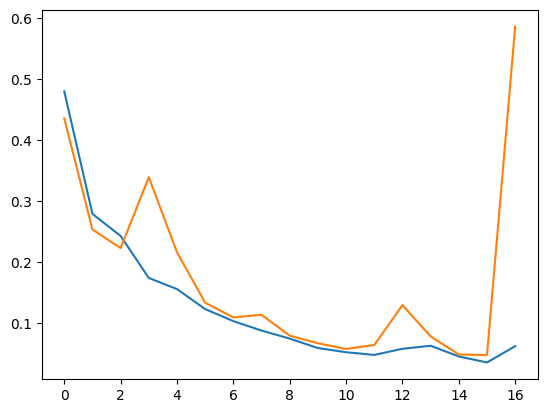

Epoch: 18
Train...


100%|██████████| 125/125 [00:09<00:00, 13.05it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.43it/s]


Mean IoU: 0.7200
	Train Loss: 0.051
	 Val. Loss: 0.103



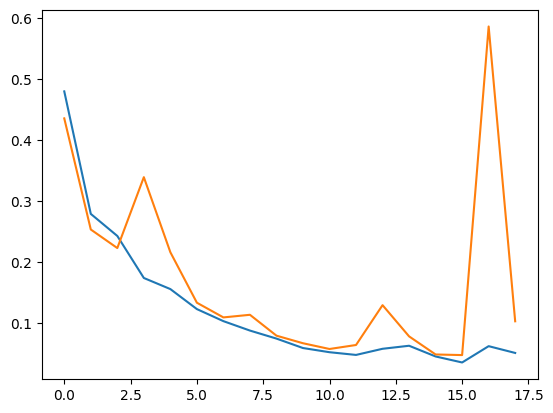

Epoch: 19
Train...


100%|██████████| 125/125 [00:09<00:00, 13.06it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.53it/s]


Mean IoU: 0.7319
Valid loss improved from 0.0475 to 0.0450. Saving checkpoint: ./best.pth
	Train Loss: 0.039
	 Val. Loss: 0.045



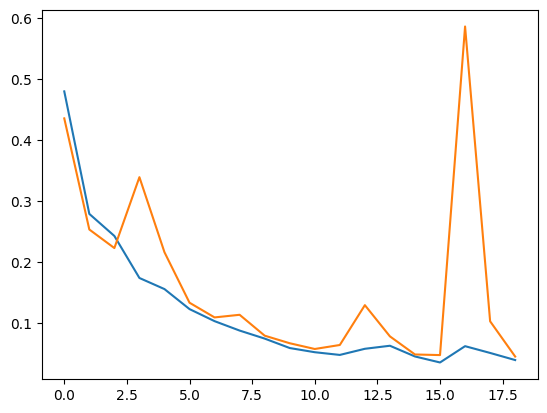

Epoch: 20
Train...


100%|██████████| 125/125 [00:09<00:00, 13.03it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.45it/s]


Mean IoU: 0.7326
Valid loss improved from 0.0450 to 0.0423. Saving checkpoint: ./best.pth
	Train Loss: 0.030
	 Val. Loss: 0.042



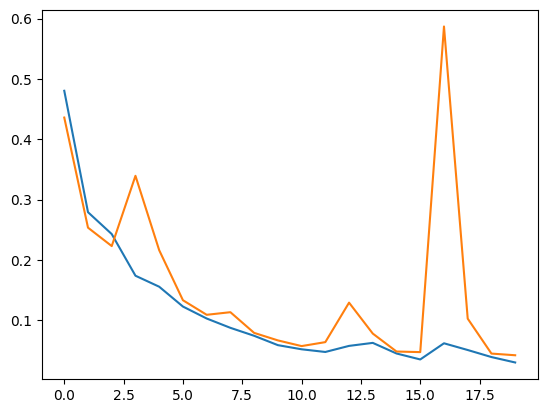

Epoch: 21
Train...


100%|██████████| 125/125 [00:09<00:00, 13.04it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.55it/s]


Mean IoU: 0.7332
Valid loss improved from 0.0423 to 0.0358. Saving checkpoint: ./best.pth
	Train Loss: 0.027
	 Val. Loss: 0.036



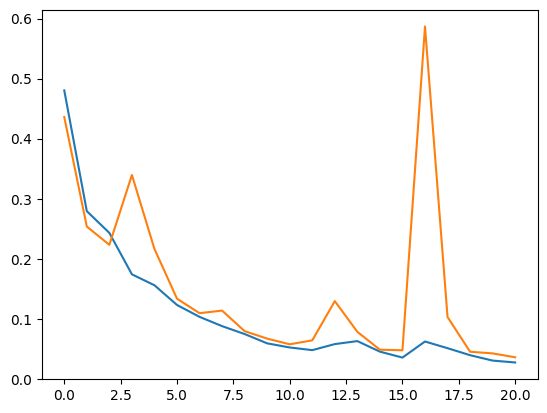

Epoch: 22
Train...


100%|██████████| 125/125 [00:09<00:00, 13.04it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.56it/s]


Mean IoU: 0.7334
Valid loss improved from 0.0358 to 0.0320. Saving checkpoint: ./best.pth
	Train Loss: 0.025
	 Val. Loss: 0.032



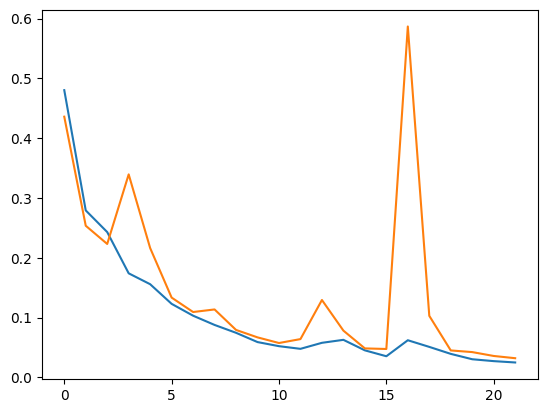

Epoch: 23
Train...


100%|██████████| 125/125 [00:09<00:00, 13.03it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.55it/s]


Mean IoU: 0.7224
	Train Loss: 0.034
	 Val. Loss: 0.113



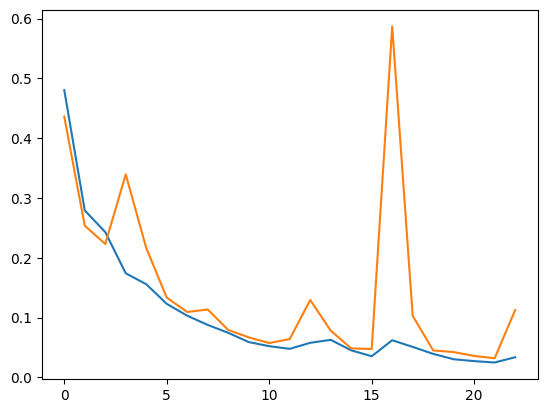

Epoch: 24
Train...


100%|██████████| 125/125 [00:09<00:00, 13.05it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.49it/s]


Mean IoU: 0.7309
	Train Loss: 0.040
	 Val. Loss: 0.045



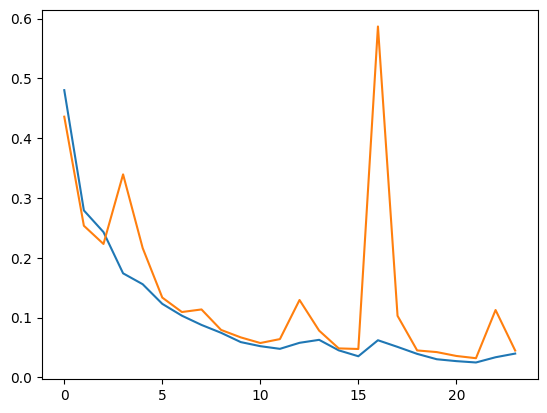

Epoch: 25
Train...


100%|██████████| 125/125 [00:09<00:00, 13.02it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.44it/s]


Mean IoU: 0.7325
	Train Loss: 0.037
	 Val. Loss: 0.043



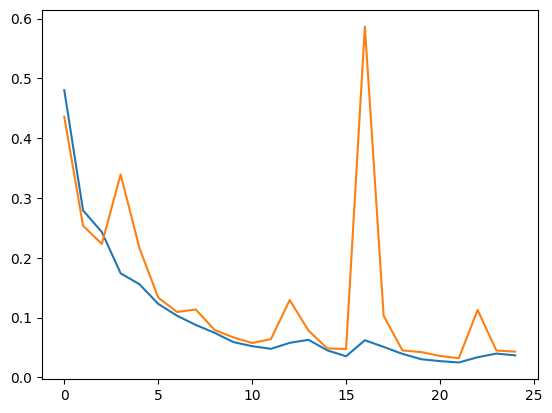

Epoch: 26
Train...


100%|██████████| 125/125 [00:09<00:00, 13.02it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.50it/s]


Mean IoU: 0.7327
	Train Loss: 0.031
	 Val. Loss: 0.036



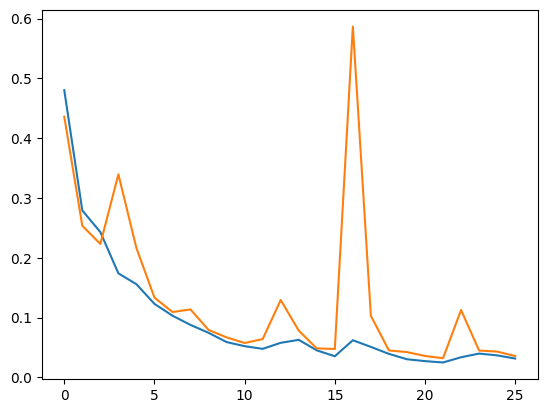

Epoch: 27
Train...


100%|██████████| 125/125 [00:09<00:00, 13.01it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.45it/s]


Mean IoU: 0.7331
Valid loss improved from 0.0320 to 0.0318. Saving checkpoint: ./best.pth
	Train Loss: 0.023
	 Val. Loss: 0.032



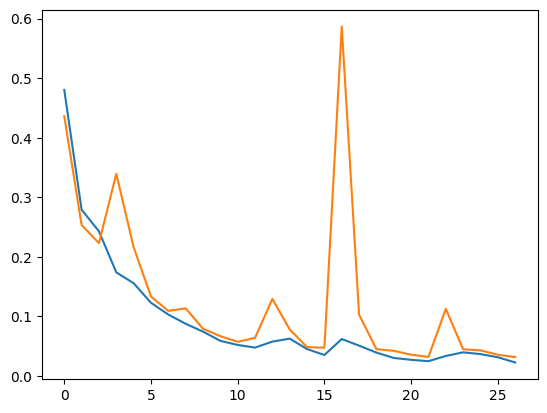

Epoch: 28
Train...


100%|██████████| 125/125 [00:09<00:00, 13.00it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.62it/s]


Mean IoU: 0.7321
	Train Loss: 0.022
	 Val. Loss: 0.036



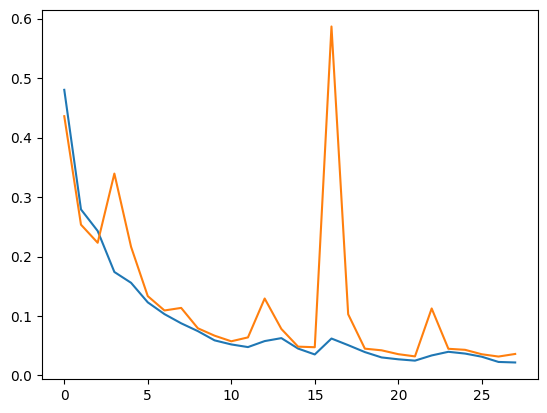

Epoch: 29
Train...


100%|██████████| 125/125 [00:09<00:00, 13.02it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.51it/s]


Mean IoU: 0.7330
	Train Loss: 0.024
	 Val. Loss: 0.037



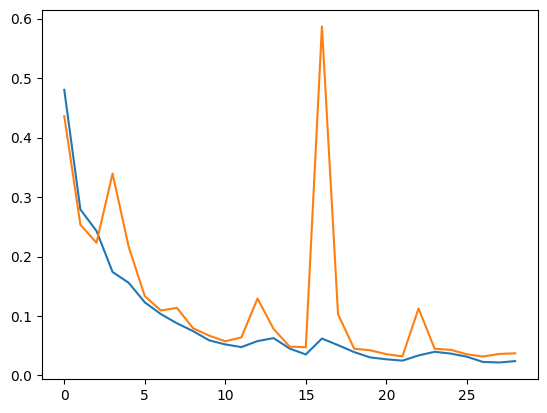

Epoch: 30
Train...


100%|██████████| 125/125 [00:09<00:00, 13.01it/s]


Valid...


100%|██████████| 50/50 [00:01<00:00, 39.49it/s]


Mean IoU: 0.7333
Valid loss improved from 0.0318 to 0.0304. Saving checkpoint: ./best.pth
	Train Loss: 0.022
	 Val. Loss: 0.030



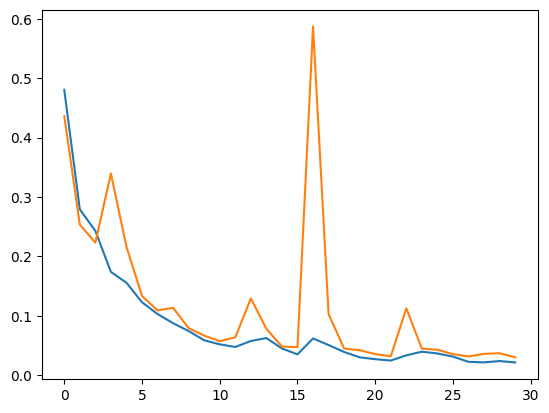

In [10]:

import os
import time
import numpy as np
from glob import glob
from PIL import Image

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import tqdm

def train(model, loader, optimizer, loss_fn, device):
    print("Train...")
    epoch_loss = 0.0

    
    model.train()
    for x, y in tqdm(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device, threshold = 0.6):
    print("Valid...")
    epoch_loss = 0.0

    iou_arr = []
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)
            
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            iou = iou_pytorch(y_pred, y)

            iou_arr.append(iou.cpu().numpy())
        mean_iou = np.mean(iou_arr)
        print('Mean IoU: {:.4f}'.format(mean_iou))
        epoch_loss = epoch_loss/len(loader)
        
    return epoch_loss


if __name__ == "__main__":
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    '''
    Code Unet for ----------  2 CLASSES ----------
    '''

    seeding(1234)
    """ Load dataset """
    train_x = sorted(glob("đường dẫn tới thư mục ảnh tập train/*")) # Lưu ý: Có dấu * phía cuối
    train_y = sorted(glob("đường dẫn tới thư mục label tập train/*"))
    valid_x = sorted(glob("đường dẫn tới thư mục ảnh train của tập test/*"))
    valid_y = sorted(glob("đường dẫn tới thư mục label của tập test/*"))

    
    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print(data_str)

    """ Hyperparameters """
    H = 80
    W = 160
    size = (W, H)
    batch_size = 4
    num_epochs = 30
    lr = 1e-4
    checkpoint_path = "./best.pth"

    """ Dataset and loader """
    train_dataset = DriveDataset(train_x, train_y, W, H)
    valid_dataset = DriveDataset(valid_x, valid_y, W, H)


    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )

    device = torch.device('cuda') 
    model = build_unet()
    model = model.to(device)

    torch.backends.cudnn.benchmark = True # new
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()

    """ Training the model """
    best_valid_loss = float("inf")

    loss_train_plt = []
    loss_val_plt = []

    for epoch in range(num_epochs):
        print("Epoch:", epoch+1)
        train_loss = train(model, train_loader, optimizer, loss_fn, device)    
        valid_loss = evaluate(model, valid_loader, loss_fn, device)
        
        """ Saving the model """
        if valid_loss < best_valid_loss:
            print(f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}")

            best_valid_loss = valid_loss
            name = os.path.join(os.getcwd(), "output_" + str(epoch) + ".pth")
            torch.save(model.state_dict(), name)

        print(f'\tTrain Loss: {train_loss:.3f}\n\t Val. Loss: {valid_loss:.3f}\n')
        
        loss_train_plt.append(train_loss)
        loss_val_plt.append(valid_loss)
        plt.plot(loss_train_plt)
        plt.plot(loss_val_plt)
        plt.show(f"loss_epoch_{epoch}.png")  

Test mô hình

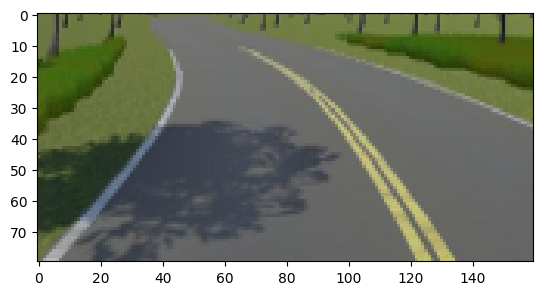

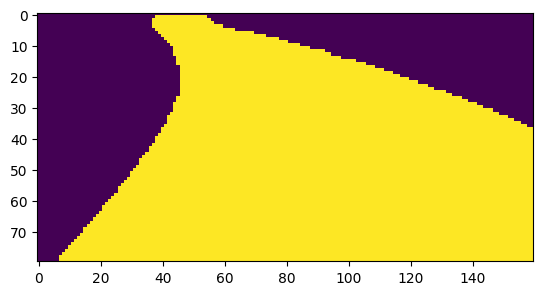

In [11]:
import cv2
import numpy as np
import torch
import time

checkpoint_path = "duong dan toi file .pth"
model = build_unet().cuda()
model.load_state_dict(torch.load(checkpoint_path, map_location='cuda'))
model.eval()

# 159, 396
img = cv2.imread("noise_lane.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (160, 80))

x = torch.from_numpy(img).cuda()
x = x.transpose(1, 2).transpose(0, 1)
x = x / 255.0
x = x.unsqueeze(0).float()
with torch.no_grad():
    pred = model(x)
    pred = torch.sigmoid(pred)
    pred = pred[0].squeeze()
    pred = (pred > 0.5).cpu().numpy()

    pred = np.array(pred, dtype=np.uint8)
    pred = pred * 255


# cv2.imwrite("pred.png", cv2.resize(pred, (160, 80)))
plt.imshow(img)
plt.show()
plt.imshow(pred)
plt.show()
